In [1]:
# import the all libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import keras
from sklearn.model_selection import StratifiedKFold
#from keras.layers.core import Dropout
import cv2
import PIL
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, callbacks

In [2]:
#let see the GPU
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
print("GPU Details:", gpus)

Num GPUs Available:  1
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#load the data set 
data = pd.read_csv("/kaggle/input/diabetic-retinopathy-resized/trainLabels_cropped.csv")# Here is  csv file image name and label
data_dir = os.listdir('/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped')# Image folder


In [4]:
data

,Unnamed: 0.1,Unnamed: 0,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1
...,...,...,...,...
35103,35104,35121,44347_right,0
35104,35105,35122,44348_left,0
35105,35106,35123,44348_right,0
35106,35107,35124,44349_left,0


In [5]:
#clean the data
def drop_columns(data_clean):
    # Drop unnecessary columns
    data_clean = data.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
    
    # Optionally modify the 'image' column to add '.jpeg' extension if it exists
    if 'image' in data_clean.columns:
        data_clean['image'] = data_clean['image'] + '.jpeg'
    
    return data_clean

In [6]:
df_data =drop_columns(data)#Here df_data is new variable data

In [7]:
df_data

,image,level
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1
...,...,...
35103,44347_right.jpeg,0
35104,44348_left.jpeg,0
35105,44348_right.jpeg,0
35106,44349_left.jpeg,0


In [8]:
#split the data
train_df, val_df = train_test_split(df_data, test_size=0.1, stratify=data['level'],random_state=42)
print(train_df.shape)
print(val_df.shape)

(31597, 2)
(3511, 2)


In [9]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5
num_classes = 5
img_height = 225
img_width = 225

# PreProcessing

In [10]:
# Define the data generator with augmentation
train_datagen = ImageDataGenerator(   # train data with data augmetataion.
    rescale=1./255,
    rotation_range=20,
    zca_whitening=True,
    brightness_range=[1, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255) #only rescale for Validation data set don need Augmentation.

/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1047: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


* contrast_range=0.2,
* brightness_range=20.,
* hue_range=10.,
* saturation_range=20.,
* blur_and_sharpen=True,
* rotate_range=180.,
* scale_range=0.2,
* shear_range=0.2,
* shift_range=0.2,
* do_mirror=True,
* need to use this

In [11]:

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/',
    x_col='image',
    y_col='level',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw')

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/',
    x_col='image',
    y_col='level',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw')

Found 31597 validated image filenames.
Found 3511 validated image filenames.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1286: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


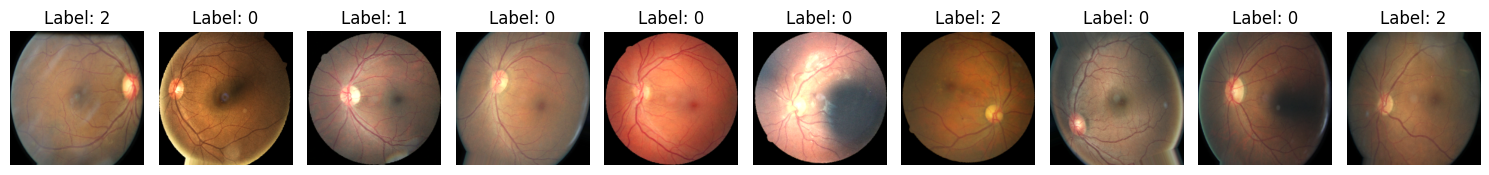

In [12]:
# Number of images to display
num_images = 10

# Retrieve a batch of images and labels
images, labels = next(train_generator)

# Plotting the images
plt.figure(figsize=(15, 10))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[i])  # Display the image
    plt.axis('off')  # Hide axis
    plt.title(f'Label: {labels[i]}')  # Display the label

plt.tight_layout()
plt.show()

In [13]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64,(7,7),strides=2, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3, 3), strides=2),  
  layers.Conv2D(128,(7,7),padding='same', activation='relu'),
  layers.Conv2D(128,(7,7),strides=2, padding='same', activation='relu'),  
  layers.Conv2D(64,(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3, 3), strides=2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),  
  layers.MaxPooling2D(pool_size=(3, 3), strides=2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 225, 225, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 113, 113, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,657,285 (6.32 MB)

 Trainable params: 1,657,285 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
Earlystopping =tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [17]:
checkpoint = callbacks.ModelCheckpoint(
    'best_model.keras',    # File path to save the model
    monitor='val_loss', # Metric to monitor
    save_best_only=True # Only save the model if 'val_loss' improves
)

In [18]:
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-5
)

In [19]:
epochs=50
history = model.fit(
  train_generator,
  validation_data=val_generator,
  epochs=epochs,callbacks = [Earlystopping,checkpoint,reduce_lr]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727514403.473723      69 service.cc:145] XLA service 0x7aa08800f340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727514403.473785      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/988 ━━━━━━━━━━━━━━━━━━━━ 4:16:11 16s/step - accuracy: 0.0625 - loss: 1.6095

I0000 00:00:1727514409.196147      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


988/988 ━━━━━━━━━━━━━━━━━━━━ 978s 975ms/step - accuracy: 0.7306 - loss: 0.9149 - val_accuracy: 0.7348 - val_loss: 0.8785 - learning_rate: 0.0010
Epoch 2/50
988/988 ━━━━━━━━━━━━━━━━━━━━ 735s 739ms/step - accuracy: 0.7381 - loss: 0.8678 - val_accuracy: 0.7348 - val_loss: 0.8722 - learning_rate: 0.0010
Epoch 3/50
988/988 ━━━━━━━━━━━━━━━━━━━━ 736s 740ms/step - accuracy: 0.7324 - loss: 0.8732 - val_accuracy: 0.7348 - val_loss: 0.8792 - learning_rate: 0.0010
Epoch 4/50
988/988 ━━━━━━━━━━━━━━━━━━━━ 727s 730ms/step - accuracy: 0.7342 - loss: 0.8735 - val_accuracy: 0.7348 - val_loss: 0.8687 - learning_rate: 0.0010
Epoch 5/50
988/988 ━━━━━━━━━━━━━━━━━━━━ 714s 718ms/step - accuracy: 0.7364 - loss: 0.8704 - val_accuracy: 0.7348 - val_loss: 0.8680 - learning_rate: 0.0010
Epoch 6/50
988/988 ━━━━━━━━━━━━━━━━━━━━ 720s 724ms/step - accuracy: 0.7334 - loss: 0.8732 - val_accuracy: 0.7348 - val_loss: 0.8696 - learning_rate: 0.0010
Epoch 7/50
988/988 ━━━━━━━━━━━━━━━━━━━━ 649s 652ms/step - accuracy: 0.7328 